In [1]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# Get Data

In [2]:
yf.pdr_override()
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

stock = 'ANTM.JK'
today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = pdr.get_data_yahoo(tickers,start=start_date, end=today)
panel_data.head(5)


[*********************100%***********************]  4 of 4 completed


Adj Close                                               Close  \
                ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277344  2421.051025  1408.559204  1530.937744  1931.946777   
2010-01-05  1576.277344  2434.768311  1437.304932  1547.488892  1931.946777   
2010-01-06  1576.277344  2421.051025  1427.723267  1555.763794  1931.946777   
2010-01-07  1610.543945  2345.607422  1437.304932  1547.488892  1973.945557   
2010-01-08  1610.543945  2359.324463  1446.887329  1539.213257  1973.945557   

                                                High          ...     Low  \
           ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

                                Open                                 Volume  \
                JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK   ANTM.JK   
Date                                                                          
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579   

                                       
           ASII.JK   ICBP.JK  JSMR.JK  
Date                                   
2010-01-04      40  26442000  6978806  
2010-01-05      40  42874000  7988164  
2010-01-06      40  44946000  7538113  
2010-01-07      40  24863000  2048787  
2010-01-08      40  19118000  2441705  

[5 rows x 24 columns]

In [3]:
data_close = panel_data["Adj Close"]
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,antm,asii,icbp,jsmr
count,3229.00000,3229.00000,3229.00000,3229.00000
mean,1132.01746,5535.38313,6113.70023,4487.74276
std,576.63816,1102.50517,2827.76893,1157.87914
min,274.09692,2290.73950,1283.99268,1398.53247
25%,740.15723,4968.08105,3967.39478,3770.00000
50%,930.56689,5624.34473,7099.25586,4573.74219
75%,1440.12805,6326.53076,8342.03906,5276.22754
max,3117.91138,7761.65576,11525.49219,6832.19727


# PLOT

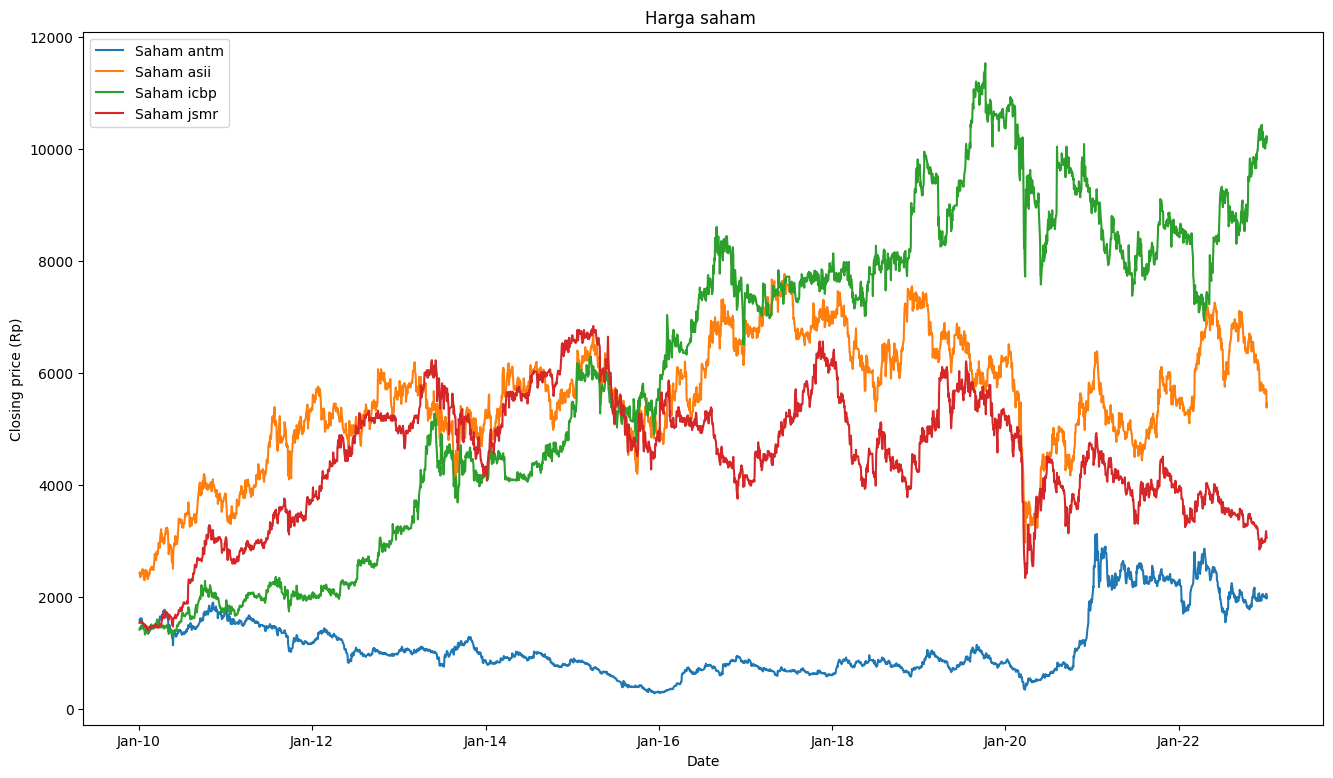

In [4]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in ['antm', 'asii', 'icbp', 'jsmr']:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

# DATA PREPERATION

In [5]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

In [7]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

In [8]:
def pembulatan(data,number):
    return np.round(data,number)

# METRICS

In [9]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham, number):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))
    print("round_up")
    print("mae score: "+str(pembulatan(mean_absolute_error(preds, y_test),number)))
    print("r2 score "+str(pembulatan(r2_score(preds, y_test),number)))
    print("mape score "+str(pembulatan(mean_absolute_percentage_error(preds, y_test),number)))
    print("rmse score "+str(pembulatan(np.sqrt(mean_squared_error(preds, y_test)),number)))

# MODEL DEFINITION

In [10]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

In [11]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(4),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

In [12]:

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

def train_model_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_rnn = Sequential([
    SimpleRNN(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(4),
    ])
    model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_rnn.summary()
    history_model_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_rnn, history_model_rnn

#time 41.8
    

In [13]:
def data_size(data):
    train_size = int(len(data) * 0.80)
    test_size = len(data) - train_size
    return train_size, test_size

# ANTM

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_antm = pd.DataFrame(data_close.antm)
df_antm = pd.DataFrame(scaler.fit_transform(df_antm), columns = ['antm'])

In [15]:
#reset index
# df_antm = reset_index_data(df_antm)
antm_train_size, antm_test_size = data_size(df_antm)
train_antm = df_antm.iloc[:antm_train_size,:].values
test_antm = df_antm.iloc[antm_train_size:len(df_antm),:].values


#data to supervised
X_train_antm, y_train_antm = split_sequence(train_antm, 2)
X_test_antm, y_test_antm = split_sequence(test_antm, 2)
        
# X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [17]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_antm_4day = [8,'relu',2,1,0.1,8,200]
model_antm_4day,history_antm_model_4day,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm_4day)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
258/258 [==============================] - 2s 4ms/step - loss: 0.0309 - mae: 0.0309 - val_loss: 0.0220 - val_mae: 0.0220
Epoch 2/200
258/258 [==============================] - 1s 3ms/step - loss: 0.0172 - mae: 0.0172 - val_loss: 0.0195 - val_mae: 0.0195
Epoch 3/200
258/258 [==============================] - 1s 3ms/step - loss: 0.0161 - mae: 0.0161 - val_loss: 0.0318 - val_mae: 0.0318
Epoch 4/200
258/258 [==============================] 

In [18]:
preds_antm_4day = model_antm_4day.predict(X_test_antm)
matriks_evaluate(preds_antm_4day,y_test_antm,'antm',4)

21/21 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.020351555956134675
r2 score 0.9724043828831694
mape score 0.03595691592369153
rmse score 0.0361938091182575
round_up
mae score: 0.0204
r2 score 0.9724
mape score 0.036
rmse score 0.0362


In [19]:
preds_antm_train_4day = model_antm_4day.predict(X_train_antm)
matriks_evaluate(preds_antm_train_4day,y_train_antm,'antm',4)

81/81 [==============================] - 0s 2ms/step
Matriks score for antm
mae score: 0.0062902220539018195
r2 score 0.9941013924823481
mape score 0.04822226374081906
rmse score 0.008928050315362783
round_up
mae score: 0.0063
r2 score 0.9941
mape score 0.0482
rmse score 0.0089


In [22]:
preds_antm_4day = pd.DataFrame(scaler.inverse_transform(preds_antm_4day))
preds_antm_4day

,0
0,1453083.750
1,1496160.375
2,1446942.875
3,1477881.625
4,1507991.625
...,...
639,5608279.000
640,5591098.000
641,5655593.500
642,5807184.000
